In [1]:
import pymunk
import random
import pygame
import cv2
import numpy as np
import os
import pymunk.pygame_util 
import time
import json
import csv
from PIL import Image
import pandas as pd

pygame 2.2.0 (SDL 2.26.4, Python 3.9.20)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
img_dir     = "/home/turgay/falling_objects_dataset/img_files"  
csv_dir     = "/home/turgay/falling_objects_dataset/csv_files"

In [3]:
world_width  = 224.0
world_height = 224.0
xCenter      = world_width / 2

In [4]:
def dim():
    return random.uniform(25, 50)

def xpos(prev_block):
    prev_w = prev_block[2]  # width of the previous block
    prev_x = prev_block[0]  # X position of the previous block
    return random.uniform( prev_x - prev_w + 5,  prev_x + prev_w - 5  )

def ypos(prev_block, h):
    prev_y = prev_block[1]  # Y position of the previous block
    prev_h = prev_block[3]  # height of the previous block
    return prev_y - ((prev_h/2)   +   (h  /  2)  ) 


def add_block(prev_block, is_first):
    w = dim()
    h = dim()
    x = xCenter if is_first else xpos(prev_block)
    y = ypos(prev_block, h)

    return (x, y, w, h)

def make_tower_world():
    
    ground_block = (xCenter, world_height-12.5, 50.0, 25.0)  
    
    block1 = add_block(ground_block, True)
    block2 = add_block(block1, False)
    block3 = add_block(block2, False)
    block4 = add_block(block3, False)
    return [ground_block, block1, block2, block3, block4]

In [5]:
def save_img(batch, iteration, screen):
    
#---------------------------------------------------------------------------------------------
    pygame.image.save(screen, f"{img_dir}/{np.int64(iteration / 50) + (batch * 20) }.png")
#---------------------------------------------------------------------------------------------            

In [6]:
def save_csv(block_data, batch, iteration):
    
#---------------------------------------------------------------------------------------------    
    block_data2 = []
    
    blocks_for_csv        =   [data["block"] for data in block_data[:]]
    masses_for_csv        =   [data["mass"] for data in block_data[:]]
    color_r_for_csv       =   [data["color_r"] for data in block_data[:]]   
    color_g_for_csv       =   [data["color_g"] for data in block_data[:]]
    color_b_for_csv       =   [data["color_b"] for data in block_data[:]]
        
    for block, mass, color_r, color_g, color_b in zip(blocks_for_csv, masses_for_csv, color_r_for_csv, color_g_for_csv, color_b_for_csv):
        data = {
            "position_x": block[0],
            "position_y": block[1],
            "width": block[2],
            "height": block[3],
            "mass": mass, 
            "color_r": color_r,
            "color_g": color_g,
            "color_b": color_b,
            "time"      : iteration / 50
        }
        block_data2.append(data)

#---------------------------------------------------------------------------------------------    
    
    csv_filename = f"{csv_dir}/{np.int64(iteration / 50) + (batch * 20)}.csv"
    
    # Check if CSV file exists to append or write headers
    file_exists = os.path.exists(csv_filename)
    with open(csv_filename, 'a', newline='') as csvfile:
        fieldnames = ["position_x", "position_y", "width", "height", "mass", "color_r", "color_g", "color_b", "time"]
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        
        # Write headers only if file doesn't exist
        if not file_exists:
            writer.writeheader()
        
        # Write the data of the blocks to the CSV file
        writer.writerows(block_data2)


In [125]:
def start_video(batch, fps=60):

    video_path   =   f"{video_dir}/{np.int64(batch) }.avi"
    
    video_writer = cv2.VideoWriter(
                                    video_path,
                                    cv2.VideoWriter_fourcc(*'XVID'),
                                    fps,
                                    (world_width, world_height)
                                    )
    return video_writer

In [126]:
def record_frames(video_writer, screen):

    frame = pygame.surfarray.array3d(screen)  # Get frame data from Pygame
    frame = np.transpose(frame, (1, 0, 2))    # Transpose to match OpenCV format
    frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)  # Convert to OpenCV color format
    video_writer.write(frame)  # Write frame to video file

In [127]:
def stop_video(video_writer):
    video_writer.release()

In [15]:
def animate_tower(batch):
    
    pygame.init()
    
    space         = pymunk.Space()
    space.gravity = (0, 9.8)

    screen        = pygame.display.set_mode((world_width, world_height))
    draw_options  = pymunk.pygame_util.DrawOptions(screen)

    # Add ground 
    ground = pymunk.Segment(space.static_body, (0, world_height), (world_width, world_height), 0) 
    space.add(ground)

    # Create blocks for the tower
    blocks     = make_tower_world()
    block_data = [] 

    for block in blocks:
        
        mass          = random.uniform(1, 10)
        moment        = pymunk.moment_for_box(mass, (block[2], block[3]))   # mass, size(width, height)   obj= (x, y, w, h) 
        body          = pymunk.Body(mass, moment)
        body.position = (block[0], block[1]) 

        shape   = pymunk.Poly.create_box(body, (block[2], block[3]))
        
        r = random.choice([0, 250])  
        g = random.choice([0, 250])  
        b = random.choice([0, 250]) 
                    
        shape.color = (r , g,  b, 1.0)  

        space.add(body, shape)
        block_data.append({"mass": mass, "block": block, "color_r": r, "color_g": g, "color_b": b })

    
    iteration = 0
    while iteration <= 999:  
                   
        screen.fill((255, 255, 255))  
        space.debug_draw(draw_options)
        pygame.display.flip()

        if iteration % 50  == 0:
                
            save_img(batch, iteration, screen)
            save_csv(block_data, batch, iteration)

        space.step(1 / 60.0)  # Step the physics simulation
        iteration += 1
        

    pygame.quit()

In [8]:
for i in range(10000):
    
    animate_tower(i) 



In [40]:
100 * 5 / (60)

8.333333333333334

###   Take one image from simulation : 

In [9]:
def animate_tower():
    
    pygame.init()
    
    space         = pymunk.Space()
    space.gravity = (0, 9.8)

    screen        = pygame.display.set_mode((world_width, world_height))
    draw_options  = pymunk.pygame_util.DrawOptions(screen)

    # Add ground 
    ground = pymunk.Segment(space.static_body, (0, world_height), (world_width, world_height), 0) 
    space.add(ground)

    # Create blocks for the tower
    blocks     = make_tower_world()
    block_data = []

    for block in blocks:
        
        mass          = random.randint(1, 10)
        moment        = pymunk.moment_for_box(mass, (block[2], block[3]))   # mass, size(width, height)   obj= (x, y, w, h) 
        body          = pymunk.Body(mass, moment)
        body.position = (block[0], block[1]) 

        shape   = pymunk.Poly.create_box(body, (block[2], block[3]))
        

        space.add(body, shape)
        # Assign random color for each block
        r, g, b = random.uniform(0, 255), random.uniform(0, 255), random.uniform(0, 255)
        shape.color = (r , g , b , 1.0)  # Normalize to [0, 1] for pygame
        
        # Collect block data (x, y, width, height, mass, r, g, b)
        block_data.append([block[0], block[1], block[2], block[3], mass, r, g, b, 1])  # Time is set to 1 for now


    iteration = 0
    while iteration <= 1000:  
        screen.fill((255, 255, 255))  # Clear the screen to white
        space.debug_draw(draw_options)  # Draw the physics objects
        pygame.display.flip()  # Update the display

        if iteration % 50 == 0:
            # Capture the current screen as a numpy array
            img_array = pygame.surfarray.array3d(screen)  # Shape: (width, height, 3)
            img_array = np.transpose(img_array, (1, 0, 2))  # Transpose to get the shape (height, width, 3)
            
            # Normalize the pixel values to [0, 1]
            img_array = img_array.astype(np.float32) / 255.0
            
            # Convert block data to numpy array and then to a torch tensor (5x9)
            block_tensor = np.array(block_data, dtype=np.float32)

            # Return the image and block data as a tuple
            return img_array, block_tensor
            break 
        
        space.step(1 / 60.0)  # Step the physics simulation
        iteration += 1

    pygame.quit()

In [10]:
img1, csv1   =   animate_tower() 
img2, csv2   =   animate_tower() 

In [11]:
img1.shape, csv1.shape

((512, 512, 3), (5, 9))

In [12]:
csv1

array([[256.      , 487.      , 100.      ,  50.      ,   6.      ,
          4.88413 , 105.10313 ,  79.89275 ,   1.      ],
       [256.      , 414.71515 ,  54.697342,  94.56971 ,  10.      ,
        148.59337 , 101.32673 , 212.60829 ,   1.      ],
       [280.69882 , 330.97855 ,  51.552147,  72.9035  ,   5.      ,
        235.20706 , 137.08025 , 246.60164 ,   1.      ],
       [269.1042  , 256.27405 ,  52.383003,  76.505455,   9.      ,
         43.78828 , 150.71054 , 153.71968 ,   1.      ],
       [272.73956 , 179.50304 ,  86.202835,  77.0366  ,   1.      ,
        223.37631 , 108.93578 ,  51.506134,   1.      ]], dtype=float32)

# Recover image from the csv parameters : 

In [14]:
def simulate_with_dynamics(csv_tensor, iterations=1000):
    import pygame
    import pymunk
    import pymunk.pygame_util
    import numpy as np

    pygame.init()

    # Initialize Pymunk
    space = pymunk.Space()
    space.gravity = (0, 9.8)

    screen_width, screen_height = 512, 512
    screen = pygame.Surface((screen_width, screen_height))
    draw_options = pymunk.pygame_util.DrawOptions(screen)

    # Add ground
    ground = pymunk.Segment(space.static_body, (0, screen_height), (screen_width, screen_height), 0)
    space.add(ground)

    # Create blocks from CSV tensor
    for block_data in csv_tensor:
        pos_x, pos_y, width, height, mass, color_r, color_g, color_b, time = block_data

        moment = pymunk.moment_for_box(mass, (width, height))
        body = pymunk.Body(mass, moment)
        body.position = (pos_x, pos_y)

        shape = pymunk.Poly.create_box(body, (width, height))
        shape.color = (color_r, color_g, color_b, 1.0)  # Normalize RGBA
        space.add(body, shape)

    iteration = 0
    while iteration <= 1000:  
        screen.fill((255, 255, 255))  # Clear the screen to white
        space.debug_draw(draw_options)  # Draw the physics objects

        if (iteration  ==  time * 50):
            # Capture the current screen as a numpy array
            img_array = pygame.surfarray.array3d(screen)  # Shape: (width, height, 3)
            img_array = np.transpose(img_array, (1, 0, 2))  # Transpose to get the shape (height, width, 3)
            
            # Normalize the pixel values to [0, 1]
            img_array = img_array.astype(np.float32) / 255.0

            return img_array
            break 
        
        space.step(1 / 60.0)  # Step the physics simulation
        iteration += 1

    pygame.quit()


In [109]:
img_path = "/home/turgay/falling_objects_dataset/img_files/"
csv_path = "/home/turgay/falling_objects_dataset/csv_files/"

In [110]:
img_files   =    sorted([f for f in os.listdir(img_path) if f.endswith(('.png', '.jpg', '.jpeg'))])
csv_files   =    sorted([f for f in os.listdir(csv_path) if f.endswith('.csv')])

In [111]:
img_files[0]

'0.png'

In [117]:
num   =  40

In [118]:
img         = Image.open(img_path+img_files[num]).convert("RGB")  # Ensure 3-channel RGB
img_array   = np.array(img, dtype=np.float32) / 255.0  # Normalize to [0, 1]


csv_data    = pd.read_csv(csv_path+csv_files[num]).values  # Load as NumPy array

In [119]:
img_array.shape, csv_data.shape

((512, 512, 3), (5, 9))

In [25]:
csv3   =  np.array([[0.3107, 0.4556, 0.4730, 0.8434, 0.3138, 0.6682, 0.9455, 0.7667, 0.8949],
        [0.6061, 0.7066, 0.7083, 0.9563, 0.9808, 1.4506, 1.2214, 0.5285, 0.7414],
        [0.4979, 0.8268, 1.4698, 0.4862, 0.5433, 1.3203, 0.8285, 0.3876, 0.6256],
        [0.9563, 0.7660, 0.8211, 0.5290, 0.4171, 0.6010, 0.5575, 0.2970, 0.5555],
        [0.8942, 0.6090, 0.6308, 0.8067, 0.9397, 0.5962, 0.3963, 0.4744, 0.6974]]) * 100

In [26]:
csv3

array([[ 31.07,  45.56,  47.3 ,  84.34,  31.38,  66.82,  94.55,  76.67,
         89.49],
       [ 60.61,  70.66,  70.83,  95.63,  98.08, 145.06, 122.14,  52.85,
         74.14],
       [ 49.79,  82.68, 146.98,  48.62,  54.33, 132.03,  82.85,  38.76,
         62.56],
       [ 95.63,  76.6 ,  82.11,  52.9 ,  41.71,  60.1 ,  55.75,  29.7 ,
         55.55],
       [ 89.42,  60.9 ,  63.08,  80.67,  93.97,  59.62,  39.63,  47.44,
         69.74]])

In [27]:
rec_img   =   simulate_with_dynamics(csv3)

In [28]:
rec_img.shape

AttributeError: 'NoneType' object has no attribute 'shape'

TypeError: Image data of dtype object cannot be converted to float

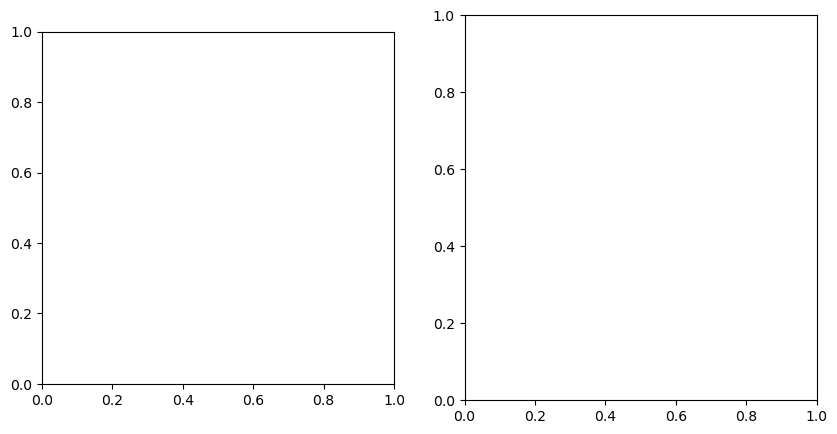

In [19]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first image in the first subplot
axes[0].imshow(rec_img)
axes[0].axis('off')  # Hide the axes for a cleaner plot
axes[0].set_title("Image array")  # Optional: Title for the first image

# Plot the second image in the second subplot
axes[1].imshow(img1)
axes[1].axis('off')  # Hide the axes for a cleaner plot
axes[1].set_title("Image original")  # Optional: Title for the second image

# Show the plot
plt.show()

In [74]:
csv_data

array([[256. , 487. , 100. ,  50. ,   6. ,  42. , 124. , 190. ,   6. ],
       [256. , 426.5,  59. ,  71. ,   7. , 131. , 254. , 246. ,   6. ],
       [288. , 349.5,  91. ,  83. ,   2. ,  48. , 134. , 200. ,   6. ],
       [365. , 270. ,  81. ,  76. ,   7. , 119. , 166. , 179. ,   6. ],
       [412. , 186.5,  52. ,  91. ,   3. , 251. ,  37. , 103. ,   6. ]])

In [105]:
def simulate_with_dynamics(csv_tensor, iterations=500):
    import pygame
    import pymunk
    import pymunk.pygame_util
    import numpy as np

    pygame.init()

    # Initialize Pymunk
    space = pymunk.Space()
    space.gravity = (0, 9.8)

    screen_width, screen_height = 512, 512
    screen = pygame.Surface((screen_width, screen_height))
    draw_options = pymunk.pygame_util.DrawOptions(screen)

    # Add ground
    ground = pymunk.Segment(space.static_body, (0, screen_height), (screen_width, screen_height), 0)
    space.add(ground)

    # Create blocks from CSV tensor
    for block_data in csv_tensor:
        pos_x, pos_y, width, height, mass, color_r, color_g, color_b, time = block_data

        moment = pymunk.moment_for_box(mass, (width, height))
        body = pymunk.Body(mass, moment)
        body.position = (pos_x, pos_y)

        shape = pymunk.Poly.create_box(body, (width, height))
        shape.color = (color_r, color_g, color_b, 1.0)  # Normalize RGBA
        space.add(body, shape)

    iteration = 0
    while iteration <= 1000:  
        screen.fill((255, 255, 255))  # Clear the screen to white
        space.debug_draw(draw_options)  # Draw the physics objects

        if (iteration  ==  time * 50):
            # Capture the current screen as a numpy array
            img_array = pygame.surfarray.array3d(screen)  # Shape: (width, height, 3)
            img_array = np.transpose(img_array, (1, 0, 2))  # Transpose to get the shape (height, width, 3)
            
            # Normalize the pixel values to [0, 1]
            img_array = img_array.astype(np.float32) / 255.0
            
            # Convert block data to numpy array and then to a torch tensor (5x9)
            block_tensor = np.array(block_data, dtype=np.float32)

            return img_array
            break 
        
        space.step(1 / 60.0)  # Step the physics simulation
        iteration += 1

    pygame.quit()


In [106]:
final_image = simulate_with_dynamics(csv_data)

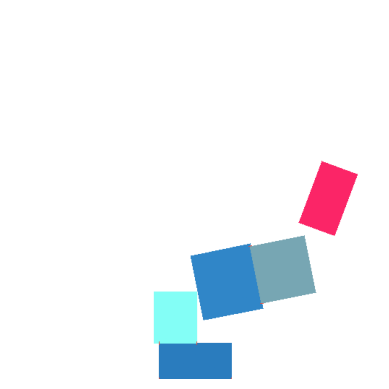

In [107]:
import matplotlib.pyplot as plt
plt.imshow(final_image)
plt.axis('off')
plt.show()